In [21]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import rasterio
from rasterio.plot import show
from rasterio.fill import fillnodata
from rasterio.vrt import WarpedVRT
import os

In [22]:
path = r'QGIS/Data/Elevation/Elevation  - NWSAS.sdat'
outpul_file = r'QGIS/Data/Elevation/Elevation  - NWSAS.tif'
with rasterio.open(path) as src:
    raster = src.read(1)
    out_meta = src.profile.copy()
    out_meta.update(driver= "GTiff",count=1,compress='lzw')
    with rasterio.open(outpul_file, "w", **out_meta) as dest:
        dest.write(raster, 1)

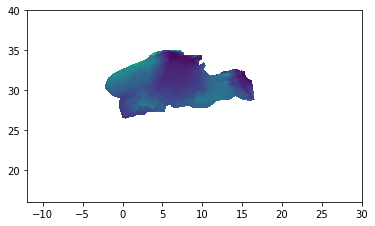

In [17]:
path = r'QGIS/Data/Elevation/Elevation  - NWSAS.tif'
with rasterio.open(path) as src:
    show(src, cmap='terrain')

In [39]:
def sample_raster(path, gdf):
    with rasterio.open(path) as src:
#         out_image = src.read(1)
#         mask = (out_image>=src.nodata)
#         out_image[out_image==src.nodata] = np.nan
#         out_image = fillnodata(out_image, mask)
#         with rasterio.open(path, "w", **src.meta) as dest:
#             dest.write(out_image, 1)
#     with rasterio.open(path) as src:
        return [float(val) for val in src.sample([(x.coords.xy[0][0], 
                                                   x.coords.xy[1][0]) for x in 
                                                   gdf['geometry']])]

In [31]:
df = pd.read_csv('nwsas_10km_data.csv')

In [32]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))

In [33]:
gdf.crs = "ESRI:102592"

In [40]:
vec = (gdf.CI==1)&((gdf.IrrigatedArea>3)|(gdf.Population>30)) 
for layer in ['srad','tmin','tmax','tavg']:
    for month in range(1,13):
        path = f'QGIS/Data/{layer}/nwsas_{layer}{month}.tif'
        gdf.loc[vec,f'{layer}_{month}'] = sample_raster(path, gdf.loc[vec].to_crs('EPSG:4326'))

In [41]:
path = r'QGIS/Data/Elevation/Elevation  - NWSAS.tif'
gdf.loc[vec,f'elevation'] = sample_raster(path, gdf.loc[vec].to_crs('EPSG:4326'))

In [42]:
gdf['lat'] = gdf.to_crs('EPSG:4326').geometry.y
gdf['long'] = gdf.to_crs('EPSG:4326').geometry.x

In [46]:
gdf.to_csv('nwsas_10km_full.gz', index=False)